In [ ]:
#!/usr/bin/env python3
#### Import all the required libraries
import pandas as pd #### Library for working with large datsets
import numpy as np #### Library for performing numerical calculations
import matplotlib.pyplot as plt #### Baasic Library for plotting graphs
#### Configuring Matplotlib to show Plots inline
%matplotlib inline 
plt.rcParams['figure.figsize'] = (12, 12) ### Setting the size of the Plots
import datetime as dt
from math import radians, cos, sin, asin, sqrt

In [ ]:
### Parsing the Date
dateparse = lambda dates: [dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S UTC') for d in dates]

In [ ]:
#### Loading the Data
data = pd.read_csv('TaxiFare.csv', parse_dates=['date_time_of_pickup'], date_parser=dateparse)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   unique_id             50000 non-null  object        
 1   amount                50000 non-null  float64       
 2   date_time_of_pickup   50000 non-null  datetime64[ns]
 3   longitude_of_pickup   50000 non-null  float64       
 4   latitude_of_pickup    50000 non-null  float64       
 5   longitude_of_dropoff  50000 non-null  float64       
 6   latitude_of_dropoff   50000 non-null  float64       
 7   no_of_passenger       50000 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB


In [ ]:
#Extract the hour and the weekday feature from the date time of pickup
data['hour_of_pickup'] = data['date_time_of_pickup'].dt.hour
data['weekday'] = pd.to_datetime(data['date_time_of_pickup']).apply(lambda x: x.weekday())
data = data.drop(['date_time_of_pickup'],1)


In [ ]:
### Lets analyse the data by grouping it by hour
data.groupby('hour_of_pickup').amount.count()

hour_of_pickup
0     1890
1     1484
2     1088
3      847
4      610
5      508
6     1017
7     1899
8     2209
9     2379
10    2259
11    2357
12    2471
13    2475
14    2471
15    2355
16    2045
17    2490
18    3077
19    3118
20    2859
21    2817
22    2808
23    2467
Name: amount, dtype: int64

In [ ]:
#### Lets Bin the hours into 4 groups - 0 - 5,5 - 14, 41 - 60, 61 +
hours_bins = [-1,1,6,11,17,22,23]
#### Since 23hrs to 1 hrs looks similar but are discontinuos, we are creating lables with the same for name for these
group_names = [1,2,3,4,5,1]
out = pd.cut(data.hour_of_pickup, bins = hours_bins, labels=group_names, ordered=False)
data['hour_of_pickup'] = out
data.groupby('hour_of_pickup').amount.count()

hour_of_pickup
1     5841
2     4070
3    11103
4    14307
5    14679
Name: amount, dtype: int64

In [ ]:
def haversine(lat1, lon1, lat2, lon2):

      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c


In [ ]:
### Use the haversine function to create a distance column
data['distance'] = 0
for index, row in data.iterrows():
    data.loc[index,'distance'] = haversine(row['latitude_of_pickup'], row['longitude_of_pickup'],row['latitude_of_dropoff'], row['longitude_of_dropoff'] )


In [ ]:
#### Lets see how the outliers are contributing and see if we can remove them based on amount and distance
print(len(data[data.distance > 30]))
print(len(data[data.amount > 50]))

120
636


In [ ]:
data = data.drop(data.index[data.distance > 30],axis = 0)
data = data.drop(data.index[data.amount > 50],axis = 0)
data = data.drop(['longitude_of_pickup'],1)
data = data.drop(['latitude_of_pickup'],1)
data = data.drop(['longitude_of_dropoff'],1)
data = data.drop(['latitude_of_dropoff'],1)
data = data.drop(['unique_id'],1)

<AxesSubplot:xlabel='distance', ylabel='amount'>

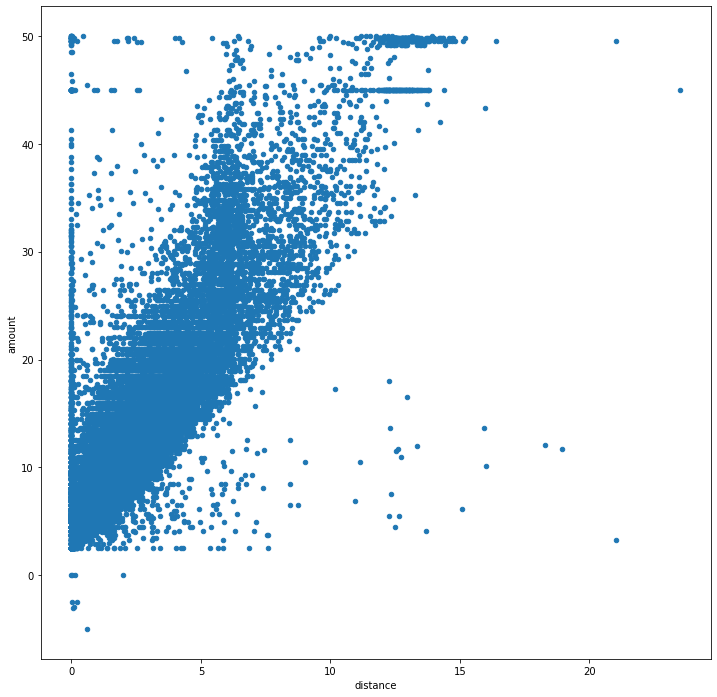

In [ ]:
data.plot.scatter(x='distance', y='amount')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49247 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   amount           49247 non-null  float64 
 1   no_of_passenger  49247 non-null  int64   
 2   hour_of_pickup   49247 non-null  category
 3   weekday          49247 non-null  int64   
 4   distance         49247 non-null  float64 
dtypes: category(1), float64(2), int64(2)
memory usage: 1.9 MB


In [ ]:
#### Extract Y & X from Data
Y = data['amount'].values
X = data
X = X.drop(['amount'],1)

#### Split X & Y into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [ ]:
#### Feature Scaling - Lets scale the Features to ensure they are all in the same range
# Feature Scaling

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
# Fitting the Random Forest Regression Model to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor( random_state = 0)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[100],'max_depth':[7,9,11,13],'max_leaf_nodes':[80,100,200]}
mdl = GridSearchCV(regressor, parameters)
mdl.fit(X_train,y_train)
mdl.best_params_

{'max_depth': 7, 'max_leaf_nodes': 80, 'n_estimators': 100}

In [ ]:
regressor = RandomForestRegressor( random_state = 0, max_depth=7, max_leaf_nodes=100,n_estimators=100)

In [ ]:
regressor.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, max_leaf_nodes=80, random_state=0)

In [ ]:
regressor.feature_importances_

array([0.00190362, 0.00935841, 0.00306588, 0.9856721 ])

In [ ]:
y_pred = regressor.predict(X_test)


In [ ]:
#### R2 Error
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.0015936194744591292


In [ ]:
#### Error Metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_test, y_pred)
print(mse)
rms = sqrt(mean_squared_error(y_test, y_pred))
print(rms)

14.426577376109721
3.798233454661485
